<a href="https://colab.research.google.com/github/vermanaman419-prog/car_sales-_predictive_model/blob/main/cas_sales_usa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car Purchase Prediction System: ML Model + Interactive Web App A complete Data Science Project

**Step 1 : imports & load**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
import joblib

# load
df = pd.read_csv('car_sales.csv')
df.columns = df.columns.str.strip()
df.head()


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


**Step 2 : Quick EDA & cleaning**

In [10]:
# quick info
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(23906, 16)
Car_id           object
Date             object
Customer Name    object
Gender           object
Annual Income     int64
Dealer_Name      object
Company          object
Model            object
Engine           object
Transmission     object
Color            object
Price ($)         int64
Dealer_No        object
Body Style       object
Phone             int64
Dealer_Region    object
dtype: object
Car_id           0
Date             0
Customer Name    1
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64


In [9]:
# preview value counts for key cols
for c in ['Company','Model','Transmission','Body Style','Dealer_Region']:
    if c in df.columns:
        print(c, "unique:", df[c].nunique())
        print(df[c].value_counts().head(10))
        print()

Company unique: 30
Company
Chevrolet     1819
Dodge         1671
Ford          1614
Volkswagen    1333
Mercedes-B    1285
Mitsubishi    1277
Chrysler      1120
Oldsmobile    1111
Toyota        1110
Nissan         886
Name: count, dtype: int64

Model unique: 154
Model
Diamante      418
Prizm         411
Silhouette    411
Passat        391
Ram Pickup    383
Jetta         382
RL            372
LS400         354
LHS           330
A6            329
Name: count, dtype: int64

Transmission unique: 2
Transmission
Auto      12571
Manual    11335
Name: count, dtype: int64

Body Style unique: 5
Body Style
SUV          6374
Hatchback    6128
Sedan        4488
Passenger    3945
Hardtop      2971
Name: count, dtype: int64

Dealer_Region unique: 7
Dealer_Region
Austin        4135
Janesville    3821
Scottsdale    3433
Pasco         3131
Aurora        3130
Greenville    3128
Middletown    3128
Name: count, dtype: int64



In [11]:
# convert Date -> datetime, extract year/month if useful
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [8]:
# fix column types
df['Annual Income'] = pd.to_numeric(df['Annual Income'], errors='coerce')
df['Price ($)'] = pd.to_numeric(df['Price ($)'], errors='coerce')


In [7]:
# drop exact duplicates (optional)
df = df.drop_duplicates()

**Step 3 : Visualizations (EDA plots)**

**1.Top companies by sales**

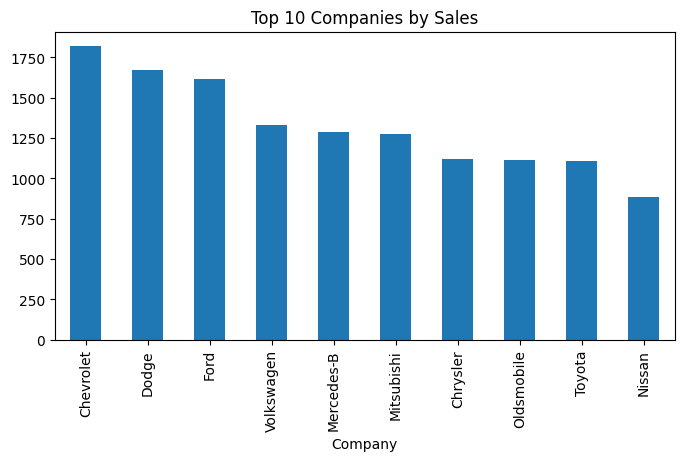

In [13]:
plt.figure(figsize=(8,4))
df['Company'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Companies by Sales')
plt.show()

**2.Price distribution**

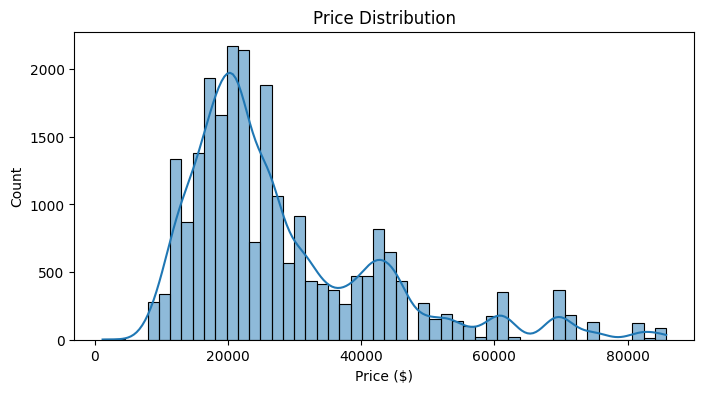

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(df['Price ($)'], bins=50, kde=True)
plt.title('Price Distribution')
plt.show()

**3.Price vs Annual Income**

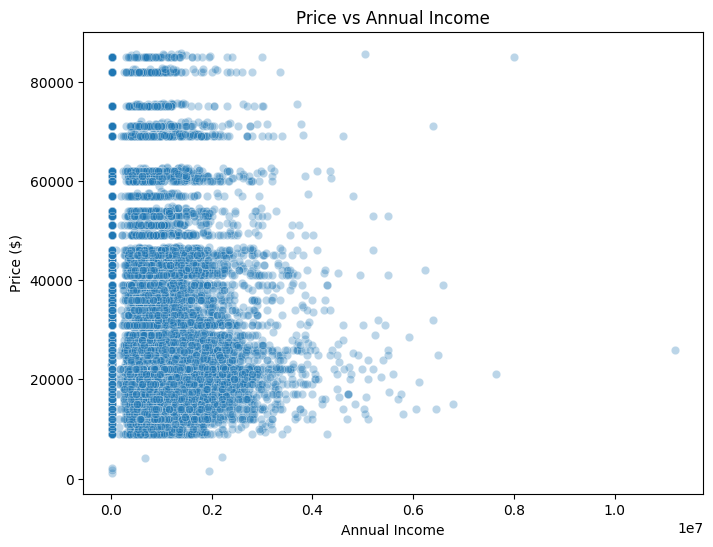

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income', y='Price ($)', data=df, alpha=0.3)
plt.title('Price vs Annual Income')
plt.show()

**4. Transmission vs Price (boxplot)**

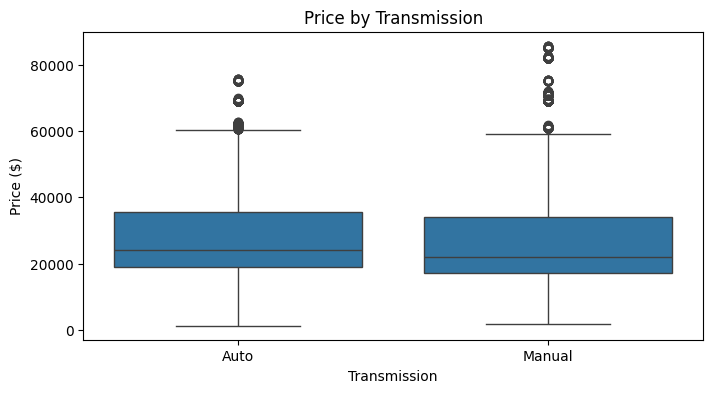

In [16]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Transmission', y='Price ($)', data=df)
plt.title('Price by Transmission')
plt.show()

**5.Body style counts by region**

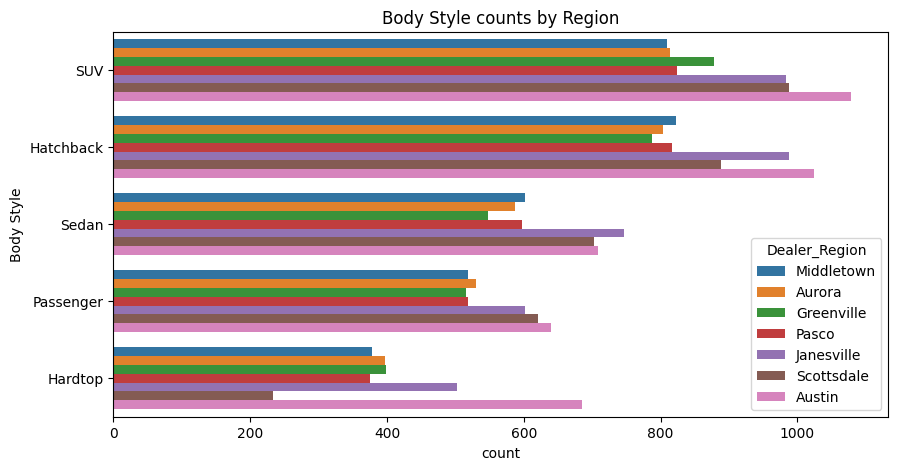

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(y='Body Style', hue='Dealer_Region', data=df, order=df['Body Style'].value_counts().index)
plt.title('Body Style counts by Region')
plt.show()

**6.Monthly sales trend (if Date available)**

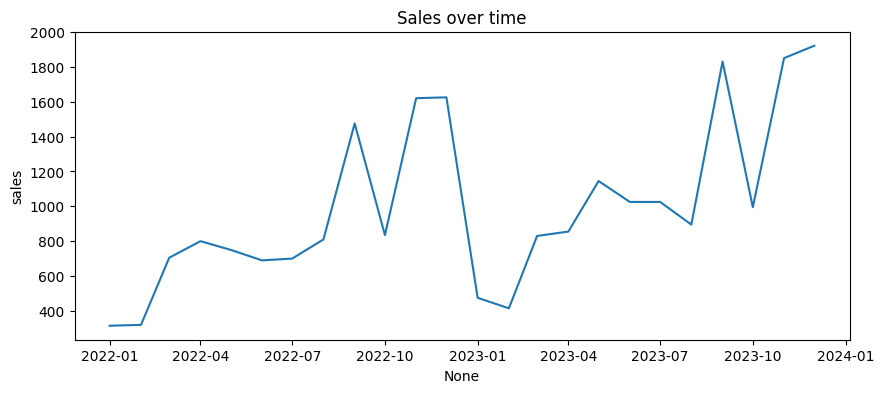

In [18]:
sales_by_month = df.groupby(['Year','Month']).size().reset_index(name='sales')
plt.figure(figsize=(10,4))
sns.lineplot(x=pd.to_datetime(sales_by_month.assign(day=1)[['Year','Month','day']]), y='sales', data=sales_by_month)
plt.title('Sales over time')
plt.show()

**Step 4 : Prepare labels & handle rare categories**

In [49]:
# Inspect distribution of Model
model_counts = df['Model'].value_counts()
model_counts.head(20)

# Keeping top N models
TOP_N = 60
top_models = model_counts.nlargest(TOP_N).index
df['Model_reduced'] = df['Model'].where(df['Model'].isin(top_models))

# Grouping rare companies
company_counts = df['Company'].value_counts()
top_companies = company_counts.nlargest(30).index
df['Company_reduced'] = df['Company'].where(df['Company'].isin(top_companies))


**Step 5 : Define features and target(s)**

In [22]:
features = ['Annual Income', 'Transmission', 'Body Style']   # user-specified inputs
# ensure columns exist
for c in features:
    assert c in df.columns, f"Missing {c} in dataframe"

# Targets
target_company = 'Company_reduced'
target_model = 'Model_reduced'
target_price = 'Price ($)'

# Drop rows with missing targets or features
train_df = df.dropna(subset=features + [target_company, target_model, target_price])


**Step 6 : Preprocessing pipelines**

In [23]:
# Fixed Step 5: preprocessing that works with different sklearn versions
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['Annual Income']
categorical_features = ['Transmission', 'Body Style']

numeric_transformer = StandardScaler()

# create OneHotEncoder in a way that works across sklearn versions
try:
    # sklearn >= 1.2
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # older sklearn
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit and transform (using train_df[features] from earlier steps)
X = preprocessor.fit_transform(train_df[features])
print("Feature matrix shape:", X.shape)

# Get human-readable feature names (robust)
try:
    ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except Exception:
    # fallback for very old sklearn
    ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

feature_names = numeric_features + list(ohe_cols)
print("Feature names:", feature_names)


Feature matrix shape: (14609, 8)
Feature names: ['Annual Income', 'Transmission_Auto', 'Transmission_Manual', 'Body Style_Hardtop', 'Body Style_Hatchback', 'Body Style_Passenger', 'Body Style_SUV', 'Body Style_Sedan']


**Step 7 : Train separate models**

In [24]:
# split
X_full = train_df[features]
y_company = train_df[target_company]
y_model = train_df[target_model]
y_price = train_df[target_price]

X_train, X_test, y_company_train, y_company_test = train_test_split(X_full, y_company, test_size=0.2, random_state=42, stratify=y_company)
_, _, y_model_train, y_model_test = train_test_split(X_full, y_model, test_size=0.2, random_state=42, stratify=y_model)
_, _, y_price_train, y_price_test = train_test_split(X_full, y_price, test_size=0.2, random_state=42)

# Pipelines
company_clf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])
model_clf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])
price_reg = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train
company_clf.fit(X_train, y_company_train)
model_clf.fit(X_train, y_model_train)
price_reg.fit(X_train, y_price_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Transmission',
                                                   'Body Style'])])),
                ('reg',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

**Step 8: Evaluate models**

In [25]:
# Company classifier
y_company_pred = company_clf.predict(X_test)
print("Company accuracy:", accuracy_score(y_company_test, y_company_pred))
print(classification_report(y_company_test, y_company_pred))

# Model classifier
y_model_pred = model_clf.predict(X_test)
print("Model accuracy:", accuracy_score(y_model_test, y_model_pred))
print(classification_report(y_model_test, y_model_pred, zero_division=0))



Company accuracy: 0.13210130047912388
              precision    recall  f1-score   support

       Acura       0.08      0.05      0.07       128
        Audi       0.22      0.14      0.17        66
         BMW       0.10      0.08      0.09       158
       Buick       0.04      0.03      0.03        40
    Cadillac       0.12      0.11      0.11        46
   Chevrolet       0.18      0.20      0.19       264
    Chrysler       0.09      0.08      0.08       208
       Dodge       0.20      0.22      0.21       216
        Ford       0.11      0.28      0.16       156
       Honda       0.07      0.04      0.05        49
     Hyundai       0.18      0.09      0.12        33
    Infiniti       0.03      0.03      0.03        39
      Jaguar       0.11      0.06      0.07        36
        Jeep       0.00      0.00      0.00        33
       Lexus       0.19      0.14      0.16        71
     Lincoln       0.24      0.41      0.30        41
  Mercedes-B       0.11      0.08      0.09

In [26]:
# Price regressor - compatibility-safe RMSE
y_price_pred = price_reg.predict(X_test)
rmse = mean_squared_error(y_price_test, y_price_pred) ** 0.5
print("Price RMSE:", rmse)
print("Price R2:", r2_score(y_price_test, y_price_pred))


Price RMSE: 17024.47310824874
Price R2: -0.22598090926061176


**Step 9: Create a single predict function (user input - Company, Model, Price)**

In [27]:
def predict_car(annual_income, transmission, body_style):
    input_df = pd.DataFrame([{
        'Annual Income': annual_income,
        'Transmission': transmission,
        'Body Style': body_style
    }])
    pred_company = company_clf.predict(input_df)[0]
    pred_model = model_clf.predict(input_df)[0]
    pred_price = price_reg.predict(input_df)[0]
    return {'Company': pred_company, 'Model': pred_model, 'Predicted_Price': float(pred_price)}

# example
print(predict_car(annual_income=70000, transmission='Automatic', body_style='Sedan'))


{'Company': 'Lexus', 'Model': 'Mustang', 'Predicted_Price': 36085.11155132998}


**Step 10 : Save models for deployment**

In [28]:
joblib.dump(company_clf, '/content/company_clf.joblib')
joblib.dump(model_clf, '/content/model_clf.joblib')
joblib.dump(price_reg, '/content/price_reg.joblib')


['/content/price_reg.joblib']

#Creating  an interactive web app

**Step 1: Installing Packages and loading libraries**

In [29]:
!pip install flask pyngrok --quiet


In [36]:
!pip install pyngrok --quiet

In [37]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import joblib


**Step2 : loading models**

In [38]:
company_clf = joblib.load('/content/company_clf.joblib')
model_clf = joblib.load('/content/model_clf.joblib')
price_reg = joblib.load('/content/price_reg.joblib')

**Step 3 :HTML for form**

In [39]:
html = """
<!DOCTYPE html>
<html>
<head>
    <title>Car Preference Predictor</title>
    <style>
        body { font-family: Arial; text-align: center; margin-top: 50px; background-color: #f4f4f4; }
        form { background-color: #fff; padding: 30px; border-radius: 10px; display: inline-block; }
        input, select { margin: 8px; padding: 8px; width: 80%; }
        button { padding: 10px 20px; background-color: #007bff; color: white; border: none; border-radius: 5px; }
        h2 { color: #333; }
    </style>
</head>
<body>
    <h2>🚗 Car Preference Prediction</h2>
    <form action="/" method="post">
        <label>Annual Income:</label><br>
        <input type="number" name="income" required><br>
        <label>Transmission:</label><br>
        <select name="transmission" required>
            <option>Automatic</option>
            <option>Manual</option>
        </select><br>
        <label>Body Style:</label><br>
        <select name="body" required>
            <option>SUV</option>
            <option>Sedan</option>
            <option>Hatchback</option>
            <option>Coupe</option>
            <option>Truck</option>
        </select><br><br>
        <button type="submit">Predict</button>
    </form>

    {% if company %}
        <h3>🧾 Predicted Results</h3>
        <p><b>Company:</b> {{ company }}</p>
        <p><b>Model:</b> {{ model }}</p>
        <p><b>Estimated Price:</b> ${{ price }}</p>
    {% endif %}
</body>
</html>
"""



**Step4: Setting our ngrok auth token and setting up web app**

In [41]:
from pyngrok import ngrok
!ngrok config add-authtoken "ngrok config add-authtoken 35NnofzMkfjLMlXvfS7TS1whZNy_85D97goDc3AQB4C2jnxiC"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [42]:
# Start Streamlit
!streamlit run app.py &>/dev/null&



In [43]:
from pyngrok import ngrok
import re, sys, textwrap

In [44]:
raw_token = "35NnofzMkfjLMlXvfS7TS1whZNy_85D97goDc3AQB4C2jnxiC"

In [45]:
token = raw_token.strip()


In [46]:
if len(token) < 20 or re.search(r'\s', token):
    print(textwrap.dedent(f"""
    ❗ The token you provided looks suspicious (too short or contains spaces/newlines).
    Please copy the token string from:
      https://dashboard.ngrok.com/get-started/your-authtoken
    and paste JUST the token (no surrounding text).
    """))
    raise SystemExit

In [48]:
try:
    ngrok.set_auth_token(token)
    ngrok.kill()          # close any previous tunnels
    public_url = ngrok.connect(5000)
    print("✅ ngrok tunnel opened at:", public_url)
except Exception as e:
    print("❌ Failed to start ngrok:", str(e))
    print("Make sure the token is correct and your ngrok account is verified.")
    raise

✅ ngrok tunnel opened at: NgrokTunnel: "https://jene-unpulleyed-kieran.ngrok-free.dev" -> "http://localhost:5000"
